# Livrable 2 - Groupe 1

## Contenu du livrable

Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.

1. Chargement des données provenant de l'EDA (livrable 1)
2. Création du dataset
3. Définition de l'autoencodeur (CAE)
4. Entrainement
5. Métriques


## Chargement des bibliothèques

In [1]:
import os
import pathlib
import zipfile

import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.regularizers import l1_l2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

## Sélection de la source de données


In [ ]:
# ID du fichier (extrait de l'URL)
file_id = "1d0k3mXd93JM0fLLYrUZRr4Un1F_TnuHi"
dataset_path = "dataset_livrable_1"
zip_path = dataset_path + ".zip"
extract_dir = pathlib.Path(zip_path).parent / dataset_path / "photo"
reduce_dataset = True

if not os.path.exists(extract_dir):
    print(f"Le dossier '{extract_dir}' n'existe pas. Téléchargement en cours...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

    print(f"Extraction ZIP en cours...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction Zip terminée")
else:
    print(f"Le dossier '{extract_dir}' existe déjà. Téléchargement et extraction non nécessaires.")

data_dir = extract_dir
print(f"Dataset disponible dans : {data_dir}")

Le dossier 'dataset_livrable_1' existe déjà. Téléchargement et extraction non nécessaires.
Dataset disponible dans : dataset_livrable_1


## Création du dataset

Dans cette partie on prépare les données d’entrée pour l'entraînement du modèle. Le dataset d’images est automatiquement chargé depuis un répertoire, puis divisé en deux sous-ensembles : un ensemble pour l’entraînement et un autre pour la validation. Les images sont redimensionnées à une taille uniforme et regroupées par lots pour être traitées efficacement par le réseau de neurones. Comme il s’agit d’un autoencodeur, les images n’ont pas besoin de labels, le modèle apprend à reconstituer chaque image à partir d’une version bruitée.

In [4]:
validation_split = 0.2
seed = 42

batch_size = 128
img_height = 256
img_width = 256

In [5]:
# Load the dataset using image_dataset_from_directory
train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels=None,
    shuffle=False
)

val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels=None,
    shuffle=False
)

Found 9993 files.
Using 7995 files for training.
Found 9993 files.
Using 1998 files for validation.


### Image dimensions

On vérifie que les images ont bien été chargées avec les dimensions attendues.

In [5]:
for images in val_set.take(1):
    print(f"Image dimensions: {images.shape}")
    break

Image dimensions: (128, 256, 256, 3)


## Visualisation

On vérifie visuellement que les images ont bien été chargées et sont prêtes à être utilisées pour l’apprentissage du modèle.

In [6]:
def displayImagesFromDataset(dataset, label):
    plt.figure(figsize=(15, 15))
    for images in dataset.take(1):
        for i in range(5):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(label)
            plt.axis("off")

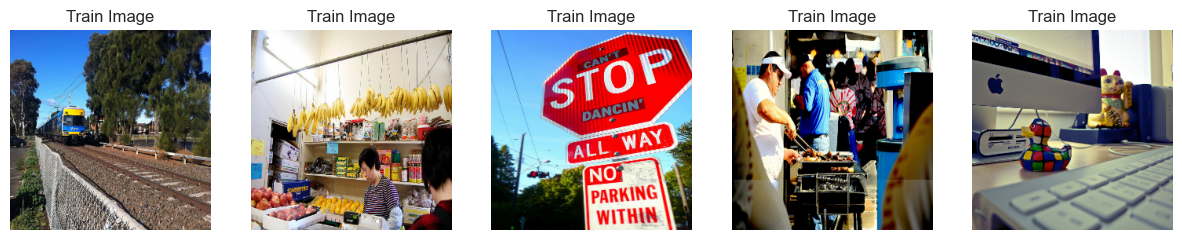

In [7]:
displayImagesFromDataset(train_set, "Train Image")

## Création des différents bruits 

Afin d'entraîner notre autoencodeur à débruiter des images, il est nécessaire de corrompre volontairement les images originales à l’aide de différentes formes de bruit. Ce code propose plusieurs fonctions permettant de simuler différents types de bruit numérique couramment rencontrés dans les images :

- Bruit gaussien : ajoute un bruit aléatoire suivant une distribution normale (gaussienne), contrôlé par un paramètre d’intensité. C’est un bruit fréquent en photographie numérique.

- Bruit de Poisson : simule les variations aléatoires liées à la nature discrète des photons. Ce bruit dépend de la luminosité de chaque pixel.

- Bruit sel et poivre : introduit de manière aléatoire des pixels noirs ou blancs, reproduisant les perturbations typiques de certaines transmissions numériques.

- Bruit uniforme : ajoute à chaque pixel une valeur aléatoire uniforme dans une plage définie.

In [6]:
def add_gaussian_noise(image, intensity=1.0, mean=0.0):
    stddev = 20.0 * intensity
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    image = tf.cast(image, tf.float32)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)
    return tf.cast(noisy_image, tf.uint8)


def add_poisson_noise(image, intensity=1.0):
    image = tf.cast(image, tf.float32)
    lam = image * intensity + 1e-3  # on adapte lambda avec l’intensité
    noisy = tf.random.poisson([], lam=lam, dtype=tf.float32)
    noisy = tf.clip_by_value(noisy, 0.0, 255.0)
    return tf.cast(noisy, tf.uint8)


def add_salt_pepper_noise(image, intensity=1.0):
    prob = 0.02 * intensity
    image = tf.cast(image, tf.float32)
    rnd = tf.random.uniform(tf.shape(image), 0, 1)

    salt = tf.cast(rnd < prob / 2, tf.float32) * 255
    pepper = tf.cast(rnd > 1 - prob / 2, tf.float32) * 0
    mask = tf.cast((rnd >= prob / 2) & (rnd <= 1 - prob / 2), tf.float32)

    noisy_image = image * mask + salt + pepper
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)
    return tf.cast(noisy_image, tf.uint8)


def add_uniform_noise(image, intensity=1.0):
    range_val = 20.0 * intensity
    minval = -range_val
    maxval = range_val
    image = tf.cast(image, tf.float32)
    noise = tf.random.uniform(tf.shape(image), minval=minval, maxval=maxval, dtype=tf.float32)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)
    return tf.cast(noisy_image, tf.uint8)

### Affichage des différents bruits

Dans cette partie, nous visualisons concrètement l'effet des différents types de bruit appliqués à nos images. À partir d'une image issue du dataset, nous générons plusieurs versions bruitées à l'aide des fonctions précédemment définies (bruit gaussien, bruit de Poisson, bruit sel et poivre, et bruit uniforme), puis nous les affichons côte à côte avec l'image originale.

Cette étape est essentielle pour :

- Comparer visuellement les effets de chaque type de perturbation,

- Mieux appréhender les défis que le modèle devra surmonter pour restaurer ces images,

- Illustrer les cas concrets que l'autoencodeur débruiteur sera amené à traiter.

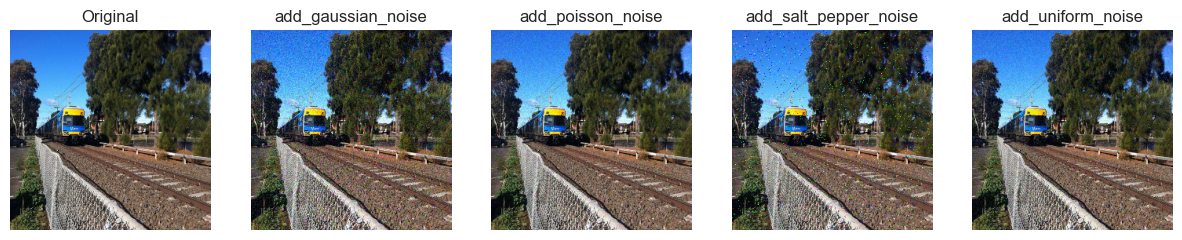

In [9]:
# Display the same image with different types of noise
def display_noisy_images(image, noise_functions):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, len(noise_functions) + 1, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    for i, noise_func in enumerate(noise_functions):
        noisy_image = noise_func(image)
        plt.subplot(1, len(noise_functions) + 1, i + 2)
        plt.imshow(noisy_image.numpy().astype("uint8"))
        plt.title(noise_func.__name__)
        plt.axis("off")

    plt.show()


# Display a sample image with different types of noise
sample_image = next(iter(train_set.take(1)))[0]  # Get the first image from the first batch
noise_functions = [add_gaussian_noise, add_poisson_noise, add_salt_pepper_noise, add_uniform_noise]
display_noisy_images(sample_image, noise_functions)

Nous appliquons à chacune des images de notre dataset un type de bruit aléatoire, choisi parmi les quatre définis précédemment (bruit gaussien, bruit sel et poivre, bruit uniforme et bruit de Poisson). À chaque appel, un type de bruit est sélectionné aléatoirement, puis appliqué à l’image.

- Cette approche présente deux avantages principaux :

- Diversification automatique des données d’entraînement, en simulant différentes perturbations réalistes ;

- Amélioration de la robustesse de l’autoencodeur, qui apprend ainsi à corriger plusieurs types de bruit sans surspécialisation sur un seul.

In [7]:
def random_noise(image):
    noise_type = tf.random.uniform([], 0, 4, dtype=tf.int32)

    def case0(): return add_gaussian_noise(image)

    def case1(): return add_salt_pepper_noise(image)

    def case2(): return add_uniform_noise(image)

    def case3(): return add_poisson_noise(image)

    return tf.switch_case(noise_type, branch_fns=[case0, case1, case2, case3])

## Préparation

In [8]:
noisy_train_set = train_set.map(lambda x: random_noise(x))
noisy_val_set = val_set.map(lambda x: random_noise(x))

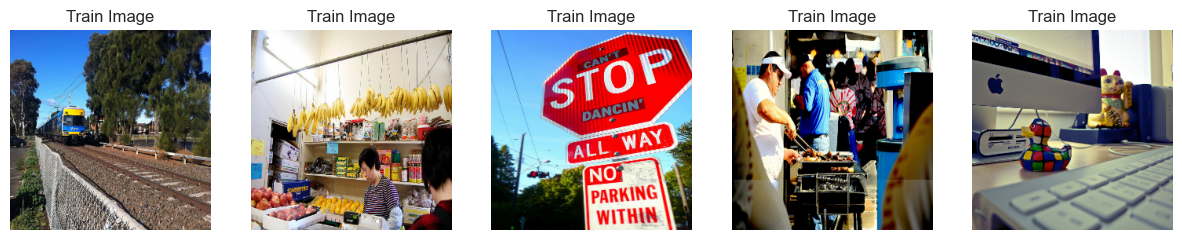

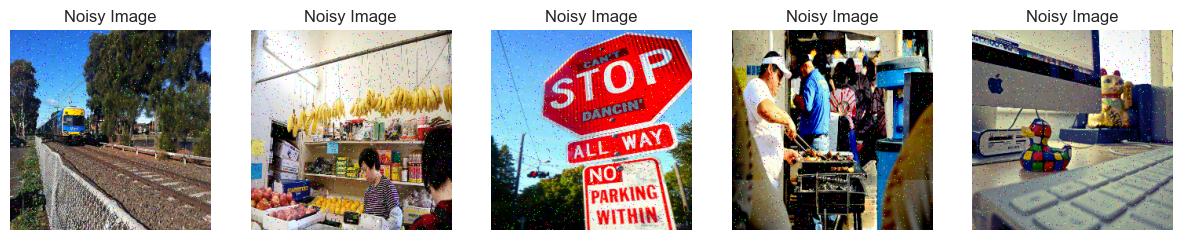

In [12]:
plt.figure(figsize=(15, 15))
for images in train_set.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Train Image")
        plt.axis("off")
plt.figure(figsize=(15, 15))
for images in noisy_train_set.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Noisy Image")
        plt.axis("off")

## Performance & pre processing

In [13]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# a_train_set = noisy_train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# a_val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)

for image in noisy_train_set.take(1):
    print(f"Image shape: {image.shape}")

for image in noisy_val_set.take(1):
    print(f"Image shape: {image.shape}")

Image shape: (128, 256, 256, 3)
Image shape: (128, 256, 256, 3)


## Modélisation

On définit l’architecture du modèle de débruitage basé sur un autoencodeur convolutionnel. Il est composé de deux parties principales :

- L’encodeur : il compresse l’image d’entrée en une représentation plus compacte appelée "espace latent". Il est constitué de plusieurs couches Conv2D (convolutions) avec des activations ReLU, combinées à des MaxPooling2D pour réduire progressivement la taille des images tout en conservant l'information essentielle.

- Le décodeur : il reconstruit l’image à partir de cette représentation comprimée. Il utilise des couches UpSampling2D pour agrandir progressivement l’image et des convolutions pour réinterpréter les données, avec une activation sigmoid en sortie afin d’obtenir des valeurs normalisées entre 0 et 1.

Un objet Autoencoder personnalisé est ensuite créé pour regrouper ces deux blocs. Cette classe permet de structurer clairement le modèle, de gérer la configuration du réseau, et de préparer le tout à l’entraînement. L’objectif est que le modèle apprenne à reconstruire les images originales à partir de leurs versions bruitées.

In [9]:
# Configurations principales de nos modèles
IMG_SIZE = img_width
NB_EPOCHS_DENOISE = 10  # nombre epoch alogithme debruiter
BATCH_SIZE = 128  # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"  # sauvegarde du modele de debruitage
LATENT_DIM = 128

### Encodeur

In [39]:
encoder = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(LATENT_DIM, (3, 3), activation='relu', padding='same'),
])


### Décodeur

In [40]:
decoder = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),

    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])


### Autoencodeur

In [41]:
from tensorflow.keras.models import Model


class Autoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
            "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
            "latent_dim": self.latent_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        print("DEBUG CONFIG:", config)  # Ajoute ceci
        encoder = tf.keras.utils.deserialize_keras_object(config.pop("encoder"))
        decoder = tf.keras.utils.deserialize_keras_object(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)


autoencoder = Autoencoder(encoder, decoder, LATENT_DIM)

### Fonction coût

Pour guider efficacement l'entraînement de l’autoencodeur, une fonction de perte combinée a été définie. Elle associe deux critères complémentaires :

- L'erreur quadratique moyenne (MSE) : mesure la différence pixel par pixel entre l’image reconstruite et l’image originale. Elle favorise la précision numérique locale.

- L’indice SSIM (Structural Similarity Index) : évalue la similarité structurelle entre deux images, en tenant compte de la luminance, du contraste et de la structure. C’est une mesure plus proche de la perception humaine.

Les deux composantes sont combinées avec un coefficient alpha qui permet de pondérer leur importance. Ce type de perte hybride permet d’obtenir des reconstructions non seulement fidèles sur le plan numérique, mais aussi visuellement plus cohérentes. Cela améliore nettement la qualité du débruitage produit par le modèle.

In [20]:
# Définition de la fonction de perte combinée
from tensorflow.keras import backend as K

# Fonction de Loss custom pour comparer avec différents résultats
@tf.keras.utils.register_keras_serializable()
def combined_mse_ssim_loss(y_true, y_pred):
    # MSE pour la précision pixel par pixel
    mse_loss = K.mean(K.square(y_true - y_pred))

    # SSIM pour la préservation de la structure
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    # Combinaison pondérée
    alpha = 0.84  # Ajustez ce coefficient selon vos besoins
    return (1 - alpha) * mse_loss + alpha * ssim

In [42]:
autoencoder.compile(
    optimizer='adam',
    loss='mse'
)
# autoencoder.summary()

encoder.summary()
decoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrainement

L’entraînement du modèle de débruitage est réalisé à l’aide de plusieurs stratégies pour optimiser la performance et éviter le surapprentissage.

Callbacks :

- EarlyStopping : ce callback surveille la perte de validation (val_loss) et arrête l’entraînement si celle-ci ne s'améliore pas pendant un certain nombre d’époques (patience=5). Il permet de restaurer les meilleurs poids du modèle pour éviter le surajustement.

- ModelCheckpoint : ce callback sauvegarde le modèle à chaque époque où une amélioration de la performance est observée. Cela permet de conserver la meilleure version du modèle durant l'entraînement.

Création des ensembles de données associés :

- Le dataset d’entraînement est constitué de paires d'images bruitées et originales, en utilisant la méthode zip pour combiner les deux ensembles de données (noisy et clean).

- Les images sont ensuite normalisées (divisées par 255) afin de les rendre compatibles avec les contraintes du réseau de neurones (valeurs entre 0 et 1).

Entraînement :

- Le modèle est ensuite entraîné avec la méthode fit, en utilisant ces paires d'images bruitées et originales. Les callbacks sont intégrés pour optimiser la gestion de l’entraînement, et la validation est effectuée sur un ensemble de données distinct (paired_val_set).

In [43]:
# log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='L2_model_mse.keras', save_best_only=True)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [44]:
# Train the model
paired_train_set = tf.data.Dataset.zip((noisy_train_set, train_set))
paired_val_set = tf.data.Dataset.zip((noisy_val_set, val_set))

paired_train_set = paired_train_set.map(lambda noisy, clean: (tf.cast(noisy, tf.float32) / 255.0, clean / 255.0))
paired_val_set = paired_val_set.map(lambda noisy, clean: (tf.cast(noisy, tf.float32) / 255.0, clean / 255.0))

In [45]:
# Train the autoencoder
history = autoencoder.fit(
    paired_train_set,
    epochs=NB_EPOCHS_DENOISE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=paired_val_set,
    callbacks=[early_stopping, model_checkpoint]  #tensorboard_callback
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - loss: 0.0472 - val_loss: 0.0121
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - loss: 0.0107 - val_loss: 0.0086
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.0079 - val_loss: 0.0066
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - loss: 0.0069 - val_loss: 0.0063
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - loss: 0.0060 - val_loss: 0.0055
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - loss: 0.0059 - val_loss: 0.0055
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 0.0051 - val_loss: 0.0049
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 0.0049 - val_loss: 0.0053
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - loss: 0.0049 - val_loss: 0.0047


## Métriques

- Courbe d'apprentisssage

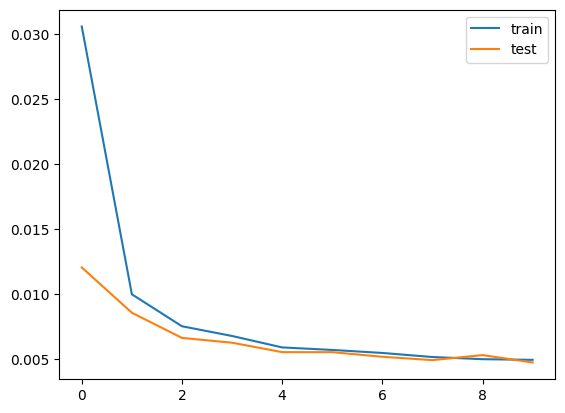

In [ ]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Val)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

Après l'entraînement du modèle, une étape cruciale consiste à évaluer visuellement ses performances. Ici, nous affichons des images bruitées et leurs images débruitées associées, côte à côte, pour apprécier les résultats du débruitage effectué par le modèle.

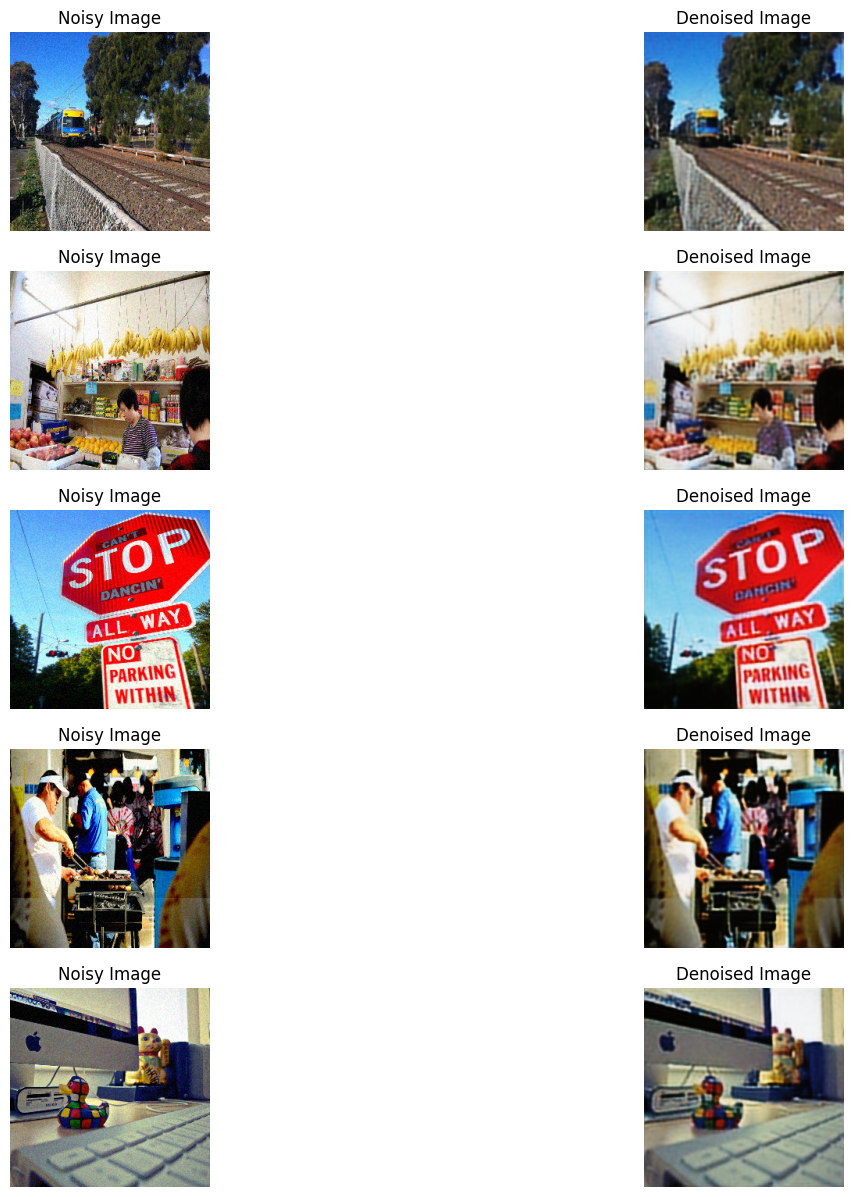

In [47]:
# Visualize noisy and denoised images side by side in columns
plt.figure(figsize=(15, 15))
for noisy_images_batch, clean_images_batch in paired_train_set.take(1):
    for i in range(5):  # Display 5 images
        # Display noisy image
        ax = plt.subplot(5, 2, 2 * i + 1)
        noisy_image = noisy_images_batch[i].numpy() * 255.0  # Scale back to [0, 255]
        plt.imshow(noisy_image.astype("uint8"))
        plt.title("Noisy Image")
        plt.axis("off")

        # Display denoised image
        denoised_image = autoencoder(noisy_images_batch[i:i + 1])  # Predict denoised image
        denoised_image = denoised_image[0].numpy() * 255.0  # Scale back to [0, 255]
        ax = plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(denoised_image.astype("uint8"))
        plt.title("Denoised Image")
        plt.axis("off")

## Evaluation sur les données de test

### Chargement du modèle

In [70]:
autoencoder = load_model('L2_model_mse_ssim.keras', custom_objects={'Autoencoder': Autoencoder})

DEBUG CONFIG: {'name': 'autoencoder', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2086316366560}, 'encoder': {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2086316366560}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2086316366560}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding'

### Chargement des données de test

In [71]:
# ID du fichier (extrait de l'URL)
file_id = "1benxHKhd_kMGb_k-2edAnFIUt1kTMwrh"
dataset_path = "dataset_livrable_2"
zip_path = dataset_path + ".zip"
parent_dir = pathlib.Path(zip_path).parent
extract_dir = parent_dir / zip_path
reduce_dataset = True

if not os.path.exists(extract_dir):
    print(f"Le dossier '{extract_dir}' n'existe pas. Téléchargement en cours...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

    print(f"Extraction ZIP en cours...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(parent_dir)
    print(f"Extraction Zip terminée")
else:
    print(f"Le dossier '{extract_dir}' existe déjà. Téléchargement et extraction non nécessaires.")

data_dir = parent_dir / "dataset_livrable_2"
print(f"Dataset disponible dans : {data_dir}")

Le dossier 'dataset_livrable_2.zip' existe déjà. Téléchargement et extraction non nécessaires.
Dataset disponible dans : dataset_livrable_2


### Création du dataset de test

In [73]:
test_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=seed,
    image_size=(img_height, img_width),
    labels=None,
    shuffle=False
)

Found 148 files.


### Utilisation du modèle et affichage

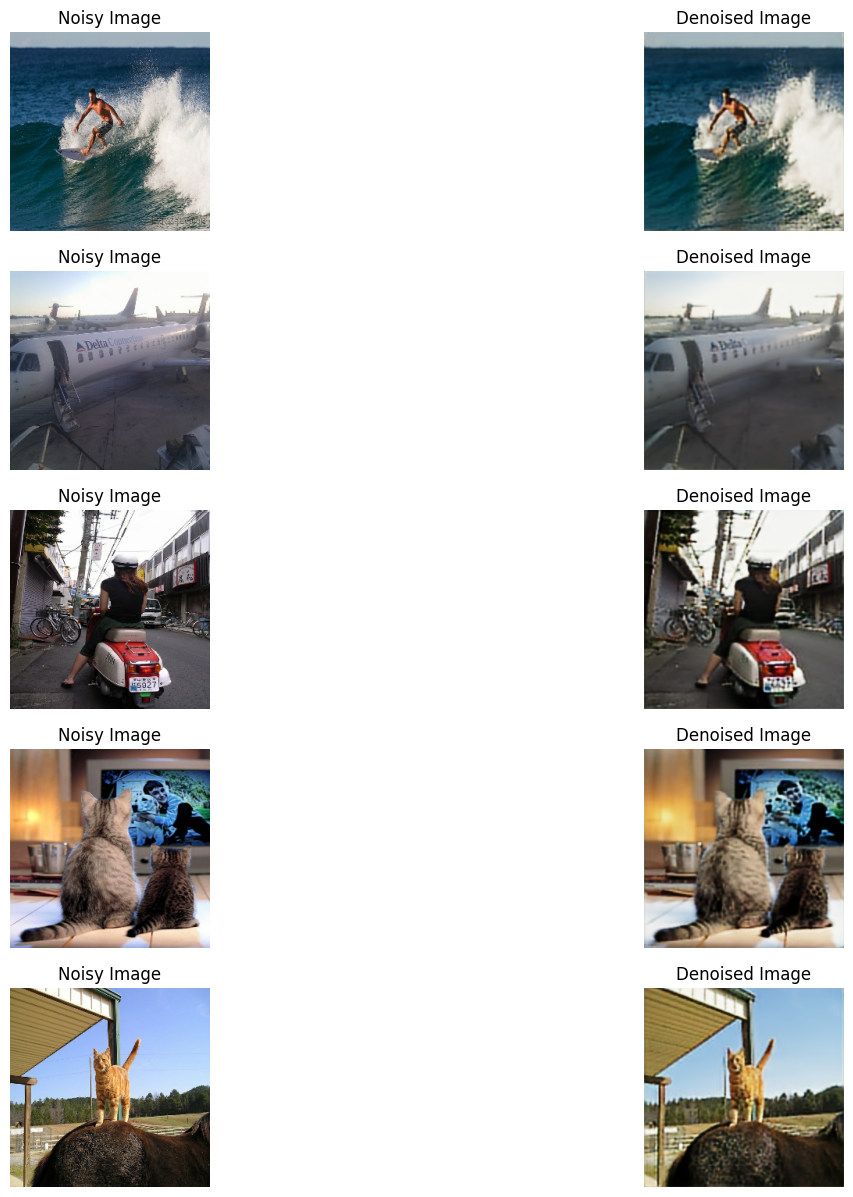

In [74]:
# Create a paired dataset of noisy and denoised images
paired_test_set = []
for noisy_images_batch in test_set:  # Iterate through the entire test set
    noisy_images_batch_normalized = noisy_images_batch / 255.0  # Normalize input to [0, 1]
    denoised_images_batch = autoencoder(noisy_images_batch_normalized)  # Predict denoised images
    paired_test_set.extend(zip(noisy_images_batch.numpy(), denoised_images_batch.numpy() * 255.0))  # Scale back to [0, 255]

# Visualize noisy and denoised images side by side
plt.figure(figsize=(15, 15))
for i, (noisy_image, denoised_image) in enumerate(paired_test_set[:5]):  # Display 5 images
    # Display noisy image
    ax = plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(noisy_image.astype("uint8"))
    plt.title("Noisy Image")
    plt.axis("off")

    # Display denoised image
    ax = plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(denoised_image.astype("uint8"))
    plt.title("Denoised Image")
    plt.axis("off")

### Métrique sur les données de test

In [75]:
from tensorflow.image import psnr, ssim

# Initialize lists to store the metrics
psnr_values = []
ssim_values = []

# Iterate through the paired_test_set
for noisy_image, denoised_image in paired_test_set:
    # Normalize the images to [0, 1] for SSIM calculation
    noisy_image_normalized = noisy_image / 255.0
    denoised_image_normalized = denoised_image / 255.0

    # Compute PSNR and SSIM
    psnr_value = psnr(noisy_image, denoised_image, max_val=255.0).numpy()
    ssim_value = ssim(noisy_image_normalized, denoised_image_normalized, max_val=1.0).numpy()

    # Append the metrics to the lists
    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)

# Calculate the average PSNR and SSIM
average_psnr = sum(psnr_values) / len(psnr_values)
average_ssim = sum(ssim_values) / len(ssim_values)

print(f"Average PSNR: {average_psnr:.2f}")
print(f"Average SSIM: {average_ssim:.4f}")

Average PSNR: 24.75
Average SSIM: 0.7953


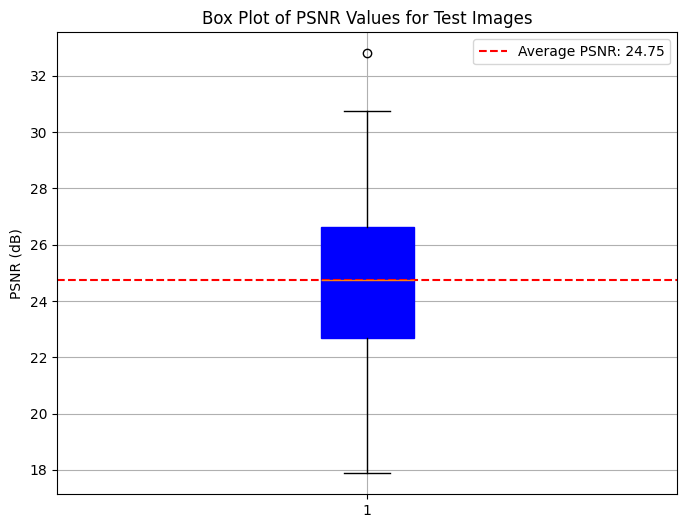

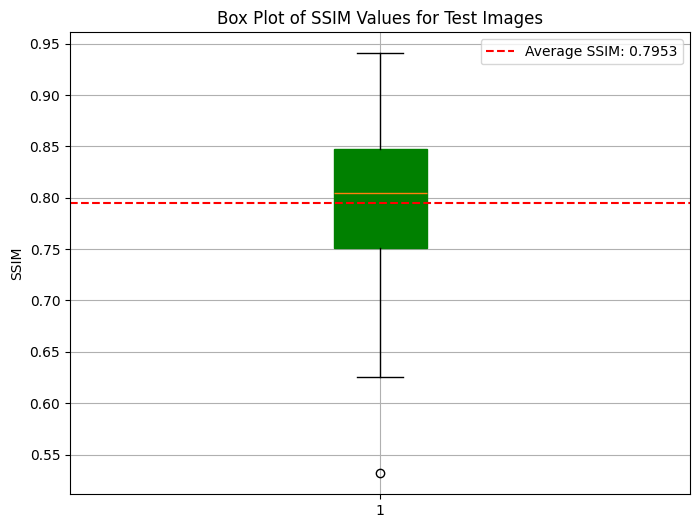

In [76]:
# Box plot for PSNR values
plt.figure(figsize=(8, 6))
plt.boxplot(psnr_values, vert=True, patch_artist=True, boxprops=dict(facecolor='blue', color='blue'))
plt.axhline(y=average_psnr, color='red', linestyle='--', label=f'Average PSNR: {average_psnr:.2f}')
plt.ylabel('PSNR (dB)')
plt.title('Box Plot of PSNR Values for Test Images')
plt.legend()
plt.grid(True)
plt.show()

# Box plot for SSIM values
plt.figure(figsize=(8, 6))
plt.boxplot(ssim_values, vert=True, patch_artist=True, boxprops=dict(facecolor='green', color='green'))
plt.axhline(y=average_ssim, color='red', linestyle='--', label=f'Average SSIM: {average_ssim:.4f}')
plt.ylabel('SSIM')
plt.title('Box Plot of SSIM Values for Test Images')
plt.legend()
plt.grid(True)
plt.show()
